# Output Conversion to `CNSGAGenerator` Style
This notebook demonstrates the use of the utility function `nsga2_to_cnsga`.
This tool converts the file output from `NSGA2Generator` into the directory of timestamped files format used in `CNSGAGenerator`.
Backwards compatibility with existing analysis codes is enabled through this function.

In [1]:
from glob import glob
import os
import shutil
import tempfile

from xopt import Xopt, Evaluator
from xopt.generators.ga.nsga2 import nsga2_to_cnsga
from xopt.generators.ga.nsga2 import NSGA2Generator
from xopt.resources.test_functions.zdt import construct_zdt
from xopt.utils import read_xopt_csv

## Generating Data
First, we will run the optimization algorithm on a test problem and output data to a temporary directory (this will be cleaned up at the end of the notebook).

In [2]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

In [3]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f'Will write data to "{output_dir}"')

Will write data to "/tmp/tmp04gjy7np"


In [4]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,
    checkpoint_freq=8,
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(64):
    X.step()

## Output Conversion
Here, we take the output from `NSGA2Generator` and convert it to the format used by `CNSGAGenerator`.

**Note**: The dates displayed in the filenames are the epoch datetime plus the generation index in seconds. This guarantees reproducible results from the same optimization data. IE, using the date and time the files were converted or the last modification date of the population file give results that depend on when the converter tool was run or when the last population was saved from the optimizer. This causes problems when the converter is run more than once (such as for continuously plotting data) as filenames will change and existing converted files may be duplicated.

In [5]:
# Make a new directory for the converted data
conv_dir = tempfile.mkdtemp()
print(f'Will write converted data to "{conv_dir}"')

Will write converted data to "/tmp/tmp4u6p_wsh"


In [6]:
# Perform the conversion
nsga2_to_cnsga(output_dir, conv_dir)

In [7]:
# Load population files
pop_files = sorted(glob(f"{conv_dir}/cnsga_population*"))
pop_files[-5:]

['/tmp/tmp4u6p_wsh/cnsga_population_1970-01-01T00_01_00+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_population_1970-01-01T00_01_01+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_population_1970-01-01T00_01_02+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_population_1970-01-01T00_01_03+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_population_1970-01-01T00_01_04+00_00.csv']

In [8]:
# Load offspring files
off_files = sorted(glob(f"{conv_dir}/cnsga_offspring*"))
off_files[-5:]

['/tmp/tmp4u6p_wsh/cnsga_offspring_1970-01-01T00_01_00+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_offspring_1970-01-01T00_01_01+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_offspring_1970-01-01T00_01_02+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_offspring_1970-01-01T00_01_03+00_00.csv',
 '/tmp/tmp4u6p_wsh/cnsga_offspring_1970-01-01T00_01_04+00_00.csv']

<Axes: xlabel='f1', ylabel='f2'>

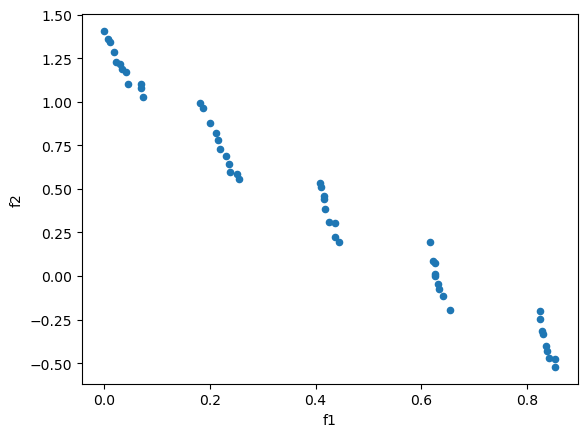

In [9]:
# Load data back in and plot Pareto front
pop_df = read_xopt_csv(pop_files[-1])
pop_df.plot.scatter("f1", "f2", marker="o")

## Partial Conversion
Sometimes the output files from the optimizer can be large.
For better performance in plotting only the final few generations, the conversion tool includes a feature to only convert the last $n$ lines of `populations.csv` and `data.csv`.
When used, no lines except the last few are even read into memory.

In [10]:
# Make a new directory for the converted data
conv_partial_dir = tempfile.mkdtemp()
print(f'Will write converted data to "{conv_partial_dir}"')

Will write converted data to "/tmp/tmpt0kbylbh"


In [11]:
# Perform the conversion (aim for last 4 generations; population_size=50)
nsga2_to_cnsga(output_dir, conv_partial_dir, last_n_lines=200)

In [12]:
# Show number of generations output (number of files = 2*generations)
print(f"Number of generations (full conversion): {len(os.listdir(conv_dir))//2}")
print(f"Number of generations (partial conversion): {len(os.listdir(conv_partial_dir))//2}")

Number of generations (full conversion): 64
Number of generations (partial conversion): 4


<Axes: xlabel='f1', ylabel='f2'>

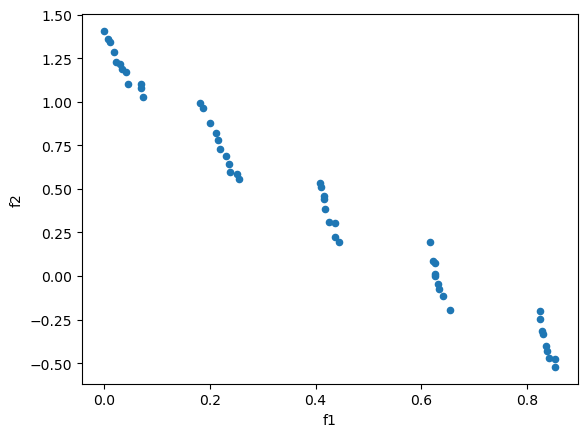

In [13]:
# Plot the final converted generation
pop_df = read_xopt_csv(sorted(glob(f"{conv_partial_dir}/cnsga_population*"))[-1])
pop_df.plot.scatter("f1", "f2", marker="o")

## Clean Up Directories
We will now clean up the temporary directories we created.

In [14]:
# Remove temp dirs
shutil.rmtree(output_dir)
shutil.rmtree(conv_dir)
shutil.rmtree(conv_partial_dir)